<a href="https://colab.research.google.com/github/haiderdares/DeepLearningFinalProject/blob/test/sp_24_DarGupShe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

In [ ]:
audio_data = load_dataset("marsyas/gtzan")

In [ ]:
print(audio_data)

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sample_audio = audio_data['train'][0]

In [ ]:
print(sample_audio)

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/blues/blues.00000.wav', 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/blues/blues.00000.wav', 'array': array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
       -0.06106567, -0.06417847]), 'sampling_rate': 22050}, 'genre': 0}


In [ ]:
audio_array = sample_audio['audio']['array']
sampling_rate = sample_audio['audio']['sampling_rate']

In [ ]:
Audio(audio_array, rate=sampling_rate)

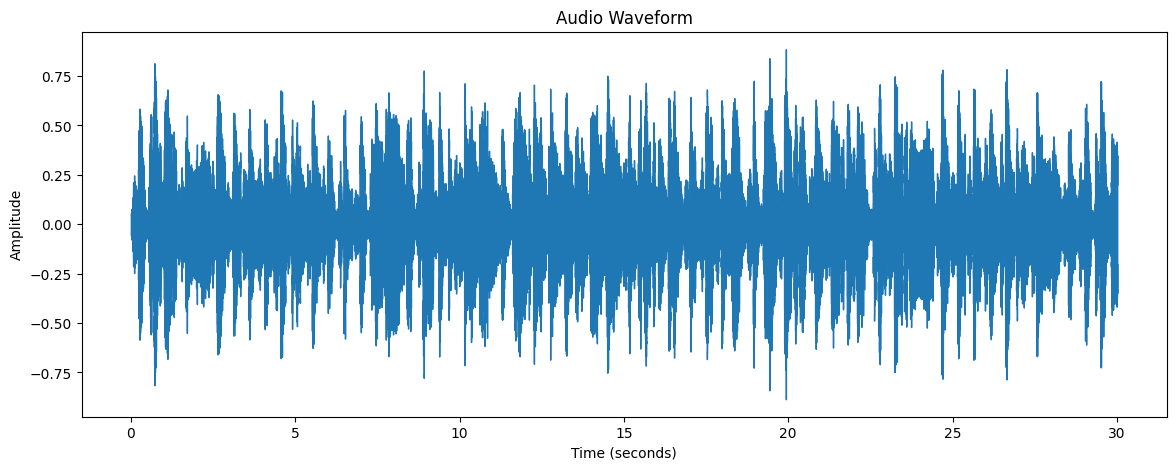

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_array, sr=sampling_rate)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Audio Waveform")
plt.show()

There can be two approaches to process this data for deep learning tasks:


*   We can convert the raw audio files into spectograms which and can then extract features from those spectograms, and convert those to a csv format
*   We can directly tensorize the data using **torchaudio**, which is optimized for pytorch




### Spectogram Approach


In [ ]:
print(f'audio array :{audio_array}')
print(f"Sampling Rate: {sampling_rate}")
print(f"Audio Shape: {audio_array.shape}")

audio array :[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]
Sampling Rate: 22050
Audio Shape: (661794,)


In [ ]:
# trimming leading and trailing silences from the audio signal
audio_file, _ = librosa.effects.trim(audio_array, top_db=20)

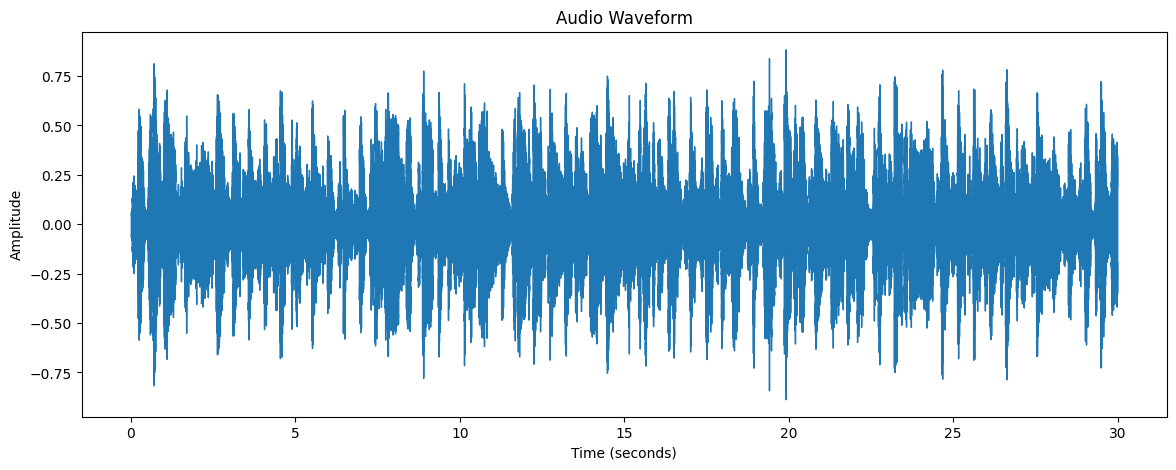

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_file, sr=sampling_rate)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Audio Waveform")
plt.show()

In [ ]:
# Applying FFT
fft_n = 2048 #fft window
hop_len = 512 #trial default
D = np.abs(librosa.stft(audio_file, n_fft=fft_n, hop_length=hop_len))
print(np.shape(D))

(1025, 1292)


 ...]

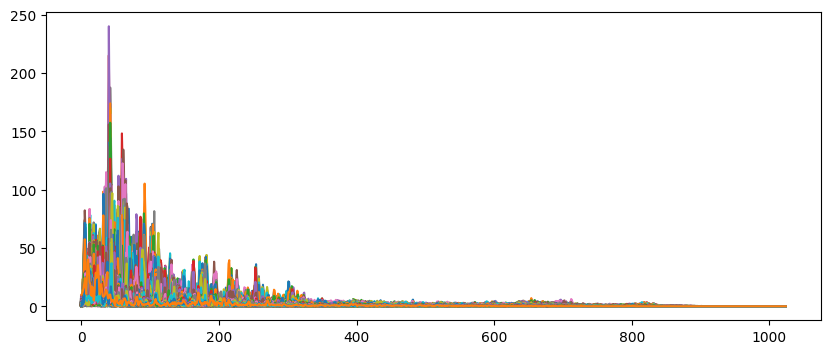

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(D)

Text(0.5, 1.0, 'Spectogram')

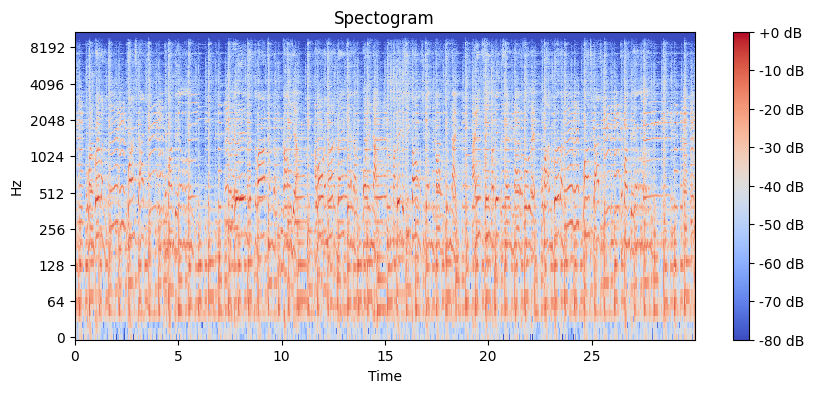

In [ ]:
db = librosa.amplitude_to_db(D, ref=np.max)
#spectogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(db, sr=sampling_rate, hop_length=hop_len, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectogram')

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


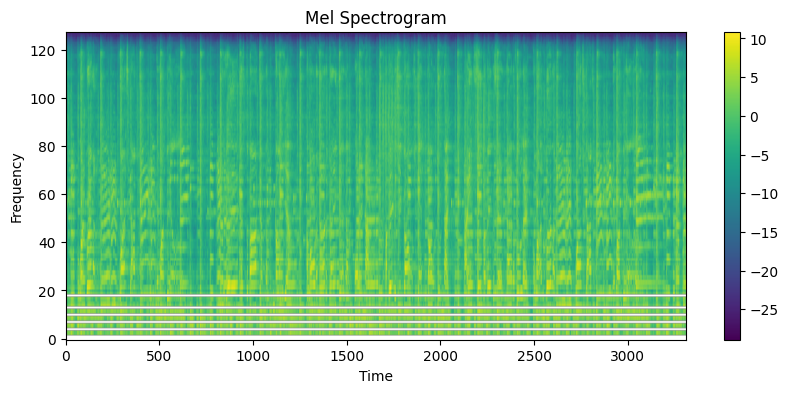

In [ ]:
import torchaudio.transforms as T
import torch

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sampling_rate,
    n_mels=128
)
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram(torch.Tensor(audio_array)).log2().numpy(), aspect='auto', origin='lower')
plt.title('Mel Spectrogram')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import os
def audio_to_spectrogram(audio_path,save_dir, n_fft=2048, hop_length=512, n_mels=128):
  """
  Converts an audio file to a spectrogram and saves it as a PyTorch Tensor.

  Args:
    audio_path: The path to the audio file.
    save_dir: The directory to save the spectrogram
    n_fft: The number of samples to use for the FFT.
    hop_length: The number of samples to shift the FFT for each frame.
    n_mels: The number of Mel bands to generate.

    Returns:
    A PyTorch Tensor representing the spectrogram.
  """

  y, sr = librosa.load(audio_path, sr=None)

  mel_spectrogram = T.MelSpectrogram(
      sample_rate=sr,
      n_fft=n_fft,
      hop_length=hop_length,
      n_mels=n_mels
  )

  mel_spectrogram_db = librosa.power_to_db(mel_spectrogram(torch.Tensor(y)).numpy(), ref=np.max)

  spectrogram_tensor = torch.from_numpy(mel_spectrogram_db)
  file_name = os.path.basename(audio_path).replace('.wav', '.pt')
  save_path = os.path.join(save_dir, file_name)
  torch.save(spectrogram_tensor, save_path)
  return spectrogram_tensor


In [ ]:
def extract_features(audio_path, n_mfcc=13):
  """Extracts features from an audio file.

  Args:
    audio_path: The path to the audio file.
    n_mfcc: The number of MFCCs to extract.

  Returns:
    A dictionary of features.
  """
  y, sr = librosa.load(audio_path, sr=None)

  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
  chroma = librosa.feature.chroma_stft(y=y, sr=sr)
  spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

  features = {
      'mfcc': mfcc,
      'chroma': chroma,
      'spectral_contrast': spectral_contrast
  }

  return features

In [ ]:
from tqdm import tqdm
def preprocess_audio(audio_data, save_dir):
  """
  Preprocesses audio data by converting it to a spectrogram and extracting features.
  Args:
    audio_data: The audio data to preprocess.
    save_dir: The directory to save the spectrogram.
  """
  spectogram_dir = os.path.join(save_dir, 'spectrograms')
  feautures_dir = os.path.join(save_dir, 'features')

  os.makedirs(spectogram_dir, exist_ok=True)
  os.makedirs(feautures_dir, exist_ok=True)

  for i in tqdm(range(len(audio_data))):
    audio_path = audio_data[i]['audio']['path']
    file_name = os.path.basename(audio_path).replace('.wav', '')
    spectrogram_path = audio_to_spectrogram(audio_path, spectogram_dir)
    features = extract_features(audio_path)
    torch.save(features, os.path.join(feautures_dir, f'{file_name}_feautures.pt'))




In [ ]:
if __name__ == '__main__':
  preprocess_audio(audio_data['train'], '/content/drive/MyDrive/preprocessed_data')

100%|██████████| 999/999 [06:33<00:00,  2.54it/s]


In [ ]:
spectogram = torch.load('audio_data/spectrograms/00000.pt')

<ipython-input-45-8f23a4d8eae5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectogram = torch.load('audio_data/spectrograms/00000.pt')


FileNotFoundError: [Errno 2] No such file or directory: 'audio_data/spectrograms/00000.pt'

# New Section